# Kaggle Instacart Competition - Aditi, Yang Yang, & Josh

We start off importing all of the packages we use the throughout this notebook

In [1]:
# For data manipulation
import pandas as pd 
import numpy as np

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

# For resource utilization
import os
import psutil # For checking on memory utilization
 
# For model and metrics  
import lightgbm as lgb
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Always check to make sure we are in the right directory
cwd = os.getcwd()
cwd

'/home/ubuntu/github/W207-InstacartKaggle'

In [3]:
# Change our working directory to the correct path
os.chdir('/home/ubuntu/data')

## We begin loading in all of the data provided by Kaggle

In [4]:
aisles = pd.read_csv('/home/ubuntu/data/aisles.csv', engine='c')
print('Total aisles: {}'.format(aisles.shape[0]))
aisles.head()

Total aisles: 134


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
# We check the memory intermittently to make sure we aren't pushing the limits
psutil.virtual_memory()

svmem(total=33737302016, available=31068876800, percent=7.9, used=2310148096, free=30203015168, active=2610233344, inactive=769101824, buffers=24068096, cached=1200070656, shared=17580032)

In [6]:
departments = pd.read_csv('/home/ubuntu/data/departments.csv', engine='c')
print('Total departments: {}'.format(departments.shape[0]))
departments.head(5)

Total departments: 21


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [7]:
products = pd.read_csv('/home/ubuntu/data/products.csv', engine='c')
print('Total products: {}'.format(products.shape[0]))
products.head(5)

Total products: 49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
orders = pd.read_csv('/home/ubuntu/data/orders.csv', engine='c')
print('Total ordered products(prior): {}'.format(orders.shape[0])) # 3M+ large
print('Unique Evaluation Set:', orders.eval_set.unique()) # Check the data
orders.head(5)

Total ordered products(prior): 3421083
Unique Evaluation Set: ['prior' 'train' 'test']


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
op_prior = pd.read_csv('/home/ubuntu/data/order_products__prior.csv', engine='c', 
                       dtype={'order_id': np.int32, 'product_id': np.int32, 
                              'add_to_cart_order': np.int16, 'reordered': np.int8})    
print('Total ordered products(train): {}'.format(op_prior.shape[0]))
op_prior.head(5)

Total ordered products(train): 32434489


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [10]:
op_train = pd.read_csv('/home/ubuntu/data/order_products__train.csv', engine='c', 
                       dtype={'order_id': np.int32, 'product_id': np.int32, 
                              'add_to_cart_order': np.int16, 'reordered': np.int8})    
print('Total ordered products(train): {}'.format(op_train.shape[0]))
op_train.head()

Total ordered products(train): 1384617


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## The two data sets below were created using SQL scripts on MS SQL server.

In [11]:
user_df = pd.read_csv('/home/ubuntu/data/InstacartUsers.csv', engine='c') 
                      # dtype={'user_id': np.int32, 'usr_distinct_prd': np.int32, 
                       #       'usr_total_prod': np.int32, 'reorder_ratio': np.float64,
                        #      'max_basketsize': np.int32, 'mean_days_since_prior': np.float64,
                         #     'eval_set'})    
print('Dimensions of users_df',user_df.shape)
user_df.head()

Dimensions of users_df (206209, 8)


,user_id,usr_distinct_prd,usr_total_prod,reorder_ratio,max_basketsize,mean_days_since_prior,eval_set,order_id
0,48895,199,400,0.037521,27,11.592593,train,1556447
1,54768,97,197,0.029283,30,11.166667,train,3059198
2,70793,63,97,0.053968,12,13.333333,test,2943081
3,163239,44,56,0.107143,3,20.000000,test,3020191
4,177462,72,366,0.063185,23,13.956522,test,1593570


In [12]:
products_x_userid = pd.read_csv('/home/ubuntu/data/OrdersXProductsGroupBy.csv', engine='c', header = None)
print('Dimensions of products_x_userid',products_x_userid.shape)
products_x_userid.columns = ['user_id', 'product_id', 'min_order_number','max_order_number','mean_cart_position']
products_x_userid.head()

Dimensions of products_x_userid (13307953, 5)


,user_id,product_id,min_order_number,max_order_number,mean_cart_position
0,100557,1,4,4,3
1,104162,1,2,9,6
2,104670,1,27,33,3
3,107775,1,14,20,7
4,10789,1,10,16,2


## In this section, we begin to shape the data and create features

In [13]:
# Adding the user ID to the orders training data
op_train = pd.merge(op_train, orders[['order_id', 'user_id']], how='inner', on='order_id')

In [14]:
# Associating aisles and departments with the product
prods = pd.merge(products, aisles, how="inner", on="aisle_id")
prods = pd.merge(prods, departments, how="inner", on="department_id")

# Deleting unnecessary rows and dfs
prods = prods.drop(['aisle_id', 'department_id'],axis=1)
del aisles, departments

# Seeing is believing
prods.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


In [15]:
# Here we create a data frame that connect the information on prior orders with the order information
orders_x_prior = pd.merge(orders,op_prior, how="inner", on="order_id")

In [16]:
# You will notice that we are now only dealing with an evaluation set of prior
orders_x_prior.eval_set.unique()

array(['prior'], dtype=object)

In [17]:
# Joining the products data with the data on orders and consumers
data = pd.merge(products_x_userid, user_df, how='inner', on='user_id')
data = pd.merge(data, prods, how='inner', on='product_id')
data.shape

(13307953, 15)

In [18]:
# Quick cleaning from the merge
data = data.rename(columns = {'user_id_x':'user_id'})

In [19]:
data.head()

,user_id,product_id,min_order_number,max_order_number,mean_cart_position,usr_distinct_prd,usr_total_prod,reorder_ratio,max_basketsize,mean_days_since_prior,eval_set,order_id,product_name,aisle,department
0,100557,1,4,4,3,16,23,0.064815,9,15.666667,test,336539,Chocolate Sandwich Cookies,cookies cakes,snacks
1,104162,1,2,9,6,48,98,0.097656,10,26.100000,train,1579878,Chocolate Sandwich Cookies,cookies cakes,snacks
2,104670,1,27,33,3,66,160,0.031208,36,7.694444,train,1776457,Chocolate Sandwich Cookies,cookies cakes,snacks
3,107775,1,14,20,7,38,96,0.049069,20,12.700000,train,3120862,Chocolate Sandwich Cookies,cookies cakes,snacks
4,10789,1,10,16,2,21,87,0.041096,36,8.777778,train,114834,Chocolate Sandwich Cookies,cookies cakes,snacks


In [20]:
# Good time to check memory!
psutil.virtual_memory()

svmem(total=33737302016, available=25786245120, percent=23.6, used=7592824832, free=24920010752, active=8571260928, inactive=80482304, buffers=24322048, cached=1200144384, shared=17580032)

In [21]:
# Lastly, bringing the training data back into the mix

data = pd.merge(data, op_train[['user_id','product_id', 'reordered']], how='left', on=['product_id','user_id'])

In [22]:
# Making Sure Our Target Is Intact

op_train['reordered'].value_counts()

data['reordered'].value_counts() # Making sure our target is still intact!

1.0    828824
Name: reordered, dtype: int64

## Splitting the data based on predesignated coding

In [23]:
df_train = data[data.eval_set == 'train']
df_test = data[data.eval_set == 'test']

In [24]:
df_train.head()

,user_id,product_id,min_order_number,max_order_number,mean_cart_position,usr_distinct_prd,usr_total_prod,reorder_ratio,max_basketsize,mean_days_since_prior,eval_set,order_id,product_name,aisle,department,reordered
1,104162,1,2,9,6,48,98,0.097656,10,26.100000,train,1579878,Chocolate Sandwich Cookies,cookies cakes,snacks,NaN
2,104670,1,27,33,3,66,160,0.031208,36,7.694444,train,1776457,Chocolate Sandwich Cookies,cookies cakes,snacks,NaN
3,107775,1,14,20,7,38,96,0.049069,20,12.700000,train,3120862,Chocolate Sandwich Cookies,cookies cakes,snacks,NaN
4,10789,1,10,16,2,21,87,0.041096,36,8.777778,train,114834,Chocolate Sandwich Cookies,cookies cakes,snacks,NaN
5,110040,1,28,6,2,49,349,0.018227,82,4.341463,train,1692257,Chocolate Sandwich Cookies,cookies cakes,snacks,NaN


In [25]:
# Looks like we need to clear some memory!
psutil.virtual_memory()
#del data, products_x_userid

svmem(total=33737302016, available=22159372288, percent=34.3, used=11219673088, free=21293109248, active=12191137792, inactive=80482304, buffers=24363008, cached=1200156672, shared=17580032)

In [26]:
# The first order by definition can have no reordered products, so we set this variable to 0 in this case
df_train['reordered'].fillna(0,inplace=True)

# Checking that we have only the values we expect
df_train.reordered.unique()

array([ 0.,  1.])

In [27]:
# Setting the target or labels for our model
target_train = df_train.loc[:,'reordered']

In [28]:
# We choose our features and create a df based on them alone
feat_for_use = ['min_order_number', 'max_order_number', 'usr_distinct_prd',
                'usr_total_prod', 'mean_cart_position', 'reorder_ratio',
                'max_basketsize','mean-days_since_prior'
               ]
df_train = df_train.loc[:,feat_for_use]

## Grid Search for parameter tuning

In [29]:
# We played around with this to see what worked well
# We tried to pass multiple parameters but that usually would blow up the grid search. Other parameters that we mannually explored
# are mentioned in comments
estimator = lgb.LGBMClassifier()

param_grid = {
    'learning_rate': [0.1], #[0.01, 0.8]
    'n_estimators': [100], #[10, 1000]
    'subsample': [0.75],
    'max_depth': [4] #[1,2,3]
}

gbm = GridSearchCV(estimator, param_grid)

gbm.fit(df_train, target_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1], 'n_estimators': [100], 'subsample': [0.75], 'max_depth': [4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [ ]:
# You may need to get rid of prior data sets in order to run the above search
del op_prior, op_train, orders, orders_x_prior, products, user_df

In [ ]:
# The best parameters from the grid search
print(gbm.best_params_)

In [30]:
df_test = df_test.loc[:, feat_for_use]

In [31]:
y_pred = gbm.predict(df_test)

[[ 0.95346823  0.04653177]
 [ 0.90141824  0.09858176]
 [ 0.97716781  0.02283219]
 ..., 
 [ 0.90132025  0.09867975]
 [ 0.96102594  0.03897406]
 [ 0.89559456  0.10440544]]


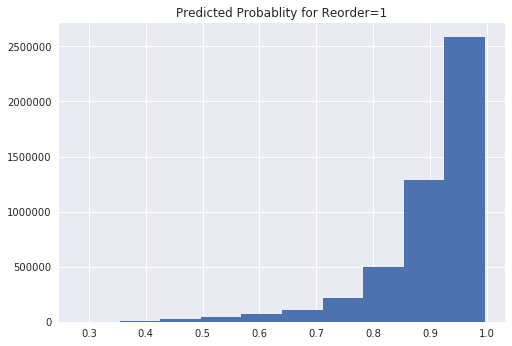

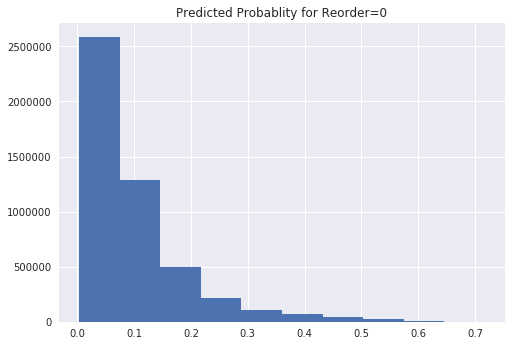

In [48]:
def G1():
    import matplotlib.pyplot as plt
    
    temp = gbm.predict_proba(df_test)
    print(temp)
    plt.hist(temp[:,0])
    plt.title("Predicted Probablity for Reorder=1")
    plt.show()
    
    plt.hist(temp[:,1])
    plt.title("Predicted Probablity for Reorder=0")
    plt.show()
    

G1()

In [32]:
y_pred.min()

0.0

In [33]:
y_pred.max()

1.0

In [ ]:
df_test['pred'] = y_pred

THRESHOLD = 0.22  # guess, should be tuned with crossval on a subset of train data

d = dict()
for row in df_test.itertuples():
    if row.pred > THRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in df_test.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)

In [ ]:
df_test.head()